In [1]:
import torch 
from collections.abc import Iterable
from datasets import load_dataset, list_datasets

# Model and tokenizer from 🤗 Transformers
from transformers import AutoModelForSequenceClassification, \
    BertForSequenceClassification, BertTokenizerFast, AutoModel, AutoTokenizer

# Code you will write for this assignment
from train_model import init_model, preprocess_dataset, init_trainer, preprocess_dataset_hatexplain
from test_model import init_tester

import numpy as np
import pickle

In [3]:
hate_speech = load_dataset("hate_speech_offensive")
split = hate_speech["train"].train_test_split(.2, seed=3463)
hate_speech["train"] = split["train"]
hate_speech["test"] = split["test"]

split = hate_speech["train"].train_test_split(.125, seed=3463)
hate_speech["train"] = split["train"]
hate_speech["val"] = split["test"]

Found cached dataset hate_speech_offensive (/Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-e8bc8b2108a4c2d9.arrow and /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-39dae8e28af0c6f7.arrow
Loading cached split indices for dataset at /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-e64f4b624f0c6ff0.arrow and /Users/junzeli/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-5be319dd2bb2bceb.arrow


In [2]:
hatexplain = load_dataset("hatexplain")
hatexplain

Found cached dataset hatexplain (/Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1924
    })
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
labels = 'original'

hate_speech["train"] = preprocess_dataset(hate_speech["train"], tokenizer, labels)
hate_speech["val"] = preprocess_dataset(hate_speech["val"], tokenizer,labels)
hate_speech["test"] = preprocess_dataset(hate_speech["test"], tokenizer, labels)

# Visualize the preprocessed dataset
for k, v in hate_speech["val"][:2].items(): 
    print("{}:\n{}\n{}\n".format(k, type(v),
                                 [item[:20] if isinstance(item, Iterable) else 
                                 item for item in v[:5]]))

Map:   0%|          | 0/17347 [00:00<?, ? examples/s]

Map:   0%|          | 0/17347 [00:00<?, ? examples/s]

Map:   0%|          | 0/17347 [00:00<?, ? examples/s]

Map:   0%|          | 0/2479 [00:00<?, ? examples/s]

Map:   0%|          | 0/2479 [00:00<?, ? examples/s]

Map:   0%|          | 0/2479 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

count:
<class 'list'>
[6, 3]

hate_speech_count:
<class 'list'>
[2, 0]

offensive_language_count:
<class 'list'>
[4, 3]

neither_count:
<class 'list'>
[0, 0]

class:
<class 'list'>
[1, 1]

tweet:
<class 'list'>
['RT @realist_iLLest: ', 'Almost done with thi']

demo_props:
<class 'list'>
[[0.26882176380724737, 0.36224836621752143, 0.0058887965306269295, 0.36304107344460435], [0.538484164995624, 0.22799105326083585, 0.005798052499449793, 0.22772672924409032]]

labels:
<class 'list'>
[1, 1]

input_ids:
<class 'list'>
[[0, 246, 5238, 3320, 10987, 524, 510, 7310, 2110, 22, 19295, 33123, 1981, 17742, 5238, 44662, 864, 31959, 22, 2443], [0, 4267, 270, 30, 33, 397, 245, 551, 639, 28, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

token_type_ids:
<class 'list'>
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

attention_mask:
<class 'list'>
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [5]:
labels = 'original'

hatexplain["train"] = preprocess_dataset_hatexplain(hatexplain["train"], tokenizer, labels)
hatexplain["validation"] = preprocess_dataset_hatexplain(hatexplain["validation"], tokenizer, labels)
hatexplain["test"] = preprocess_dataset_hatexplain(hatexplain["test"], tokenizer, labels)

Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-f2e32ec8db681754.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-3d584c012c544534.arrow
Loading cached processed dataset at /Users/junzeli/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249/cache-bd8b4bf850370dff.arrow


Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [6]:
def read_result(file):
    with open(file, 'rb') as f:
        object = pickle.load(f)
    return object

In [13]:
obj = read_result('test_results.p')

In [14]:
texts = np.array(hate_speech['test']['tweet'])
true_labels = np.array(hate_speech['test']['labels'])
len(true_labels)

4957

In [15]:
pred_labels = obj[0].argmax(axis=1)
len(pred_labels)

4957

In [26]:
sum(np.array(hate_speech['test']['labels']) == 0)

280

In [32]:
np.set_printoptions(suppress=True)

cm = np.zeros((3,3))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm[i][j] = int(sum((true_labels == i) & (pred_labels == j)))
cm

array([[   1.,  202.,   77.],
       [   0., 3643.,  237.],
       [   0.,   60.,  737.]])

Text(50.722222222222214, 0.5, 'true')

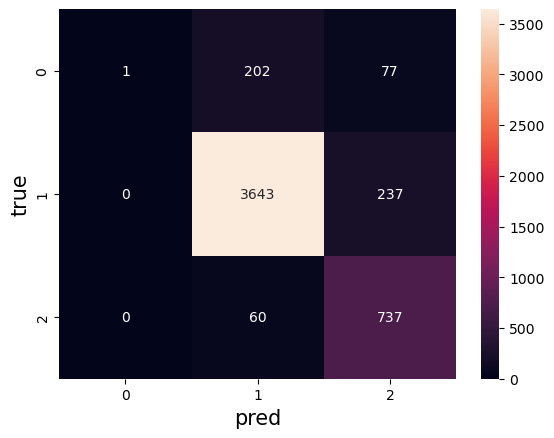

In [37]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

In [44]:
demo_arr = np.array(hate_speech['test']['demo_props'])
demo_l = []

for d in demo_arr:
    if any(d>0.6):
        demo_l.append(np.argmax(d))
    else:
        demo_l.append(-1)
demos = np.array(demo_l)
len(demos)

4957

In [45]:
np.set_printoptions(suppress=True)

cm_aa, cm_his, cm_as, cm_wh = np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm_aa[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 0)))
        cm_his[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 1)))
        cm_as[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 2)))
        cm_wh[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 3)))

Text(50.722222222222214, 0.5, 'true')

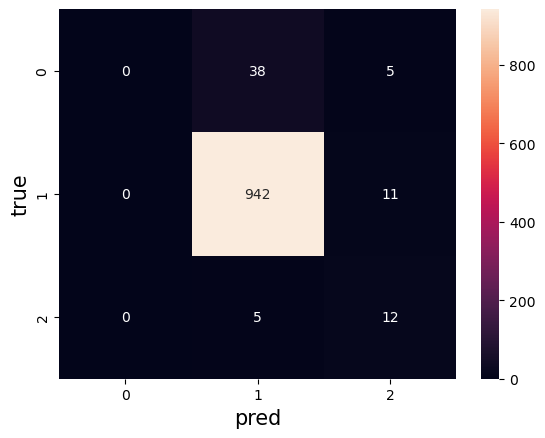

In [46]:
sn.heatmap(cm_aa, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

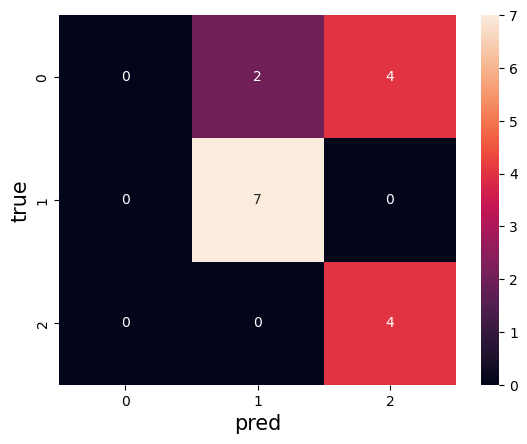

In [47]:
sn.heatmap(cm_his, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

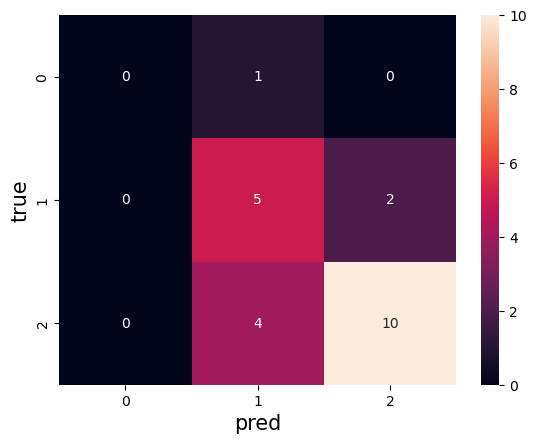

In [48]:
sn.heatmap(cm_as, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

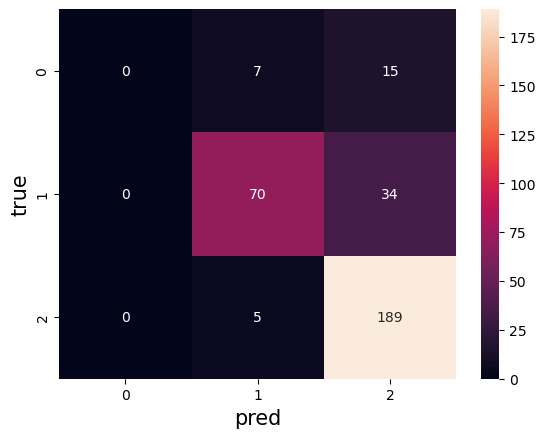

In [49]:
sn.heatmap(cm_wh, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

In [8]:
obj = read_result('test_results_hatexplain.p')

In [10]:
true_labels = np.array(hatexplain['train']['labels'])
len(true_labels)

15383

In [11]:
pred_labels = obj[0].argmax(axis=1)
len(pred_labels)

15383

In [13]:
np.set_printoptions(suppress=True)

cm = np.zeros((3,3))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm[i][j] = int(sum((true_labels == i) & (pred_labels == j)))
cm

array([[   5., 2338., 2405.],
       [   1., 2518., 3732.],
       [   1., 2283., 2100.]])

Text(50.722222222222214, 0.5, 'true')

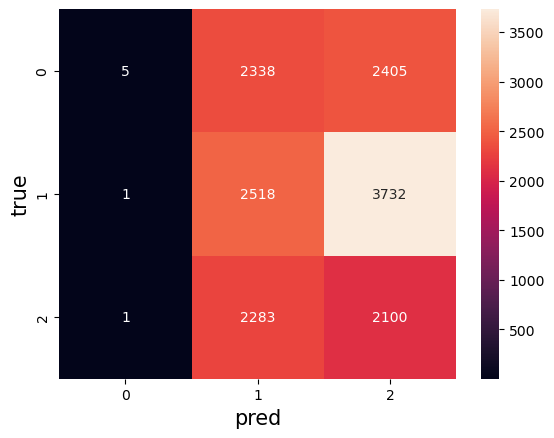

In [14]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

In [15]:
demo_arr = np.array(hatexplain['train']['demo_props'])
demo_l = []

for d in demo_arr:
    if any(d>0.6):
        demo_l.append(np.argmax(d))
    else:
        demo_l.append(-1)
demos = np.array(demo_l)
len(demos)

15383

In [16]:
np.set_printoptions(suppress=True)

cm_aa, cm_his, cm_as, cm_wh = np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cm_aa[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 0)))
        cm_his[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 1)))
        cm_as[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 2)))
        cm_wh[i][j] = int(sum((true_labels == i) & (pred_labels == j) & (demos == 3)))

Text(50.722222222222214, 0.5, 'true')

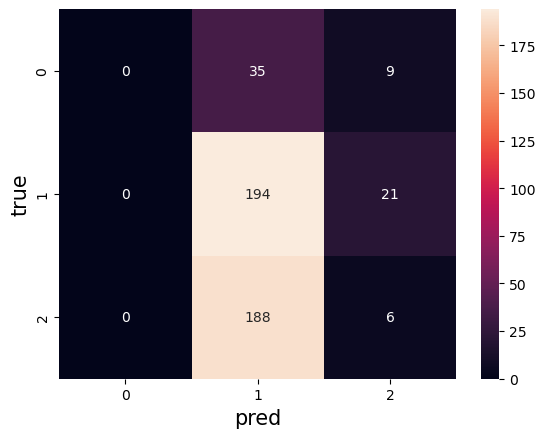

In [17]:
sn.heatmap(cm_aa, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

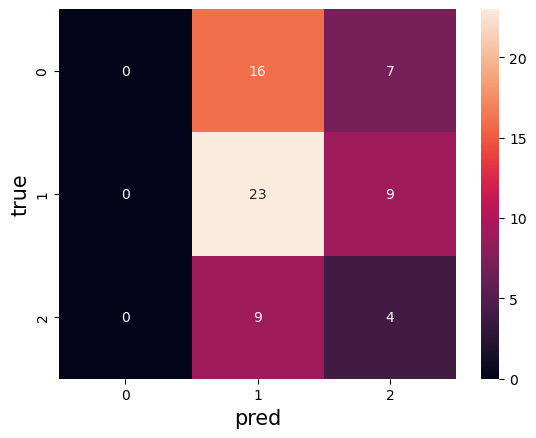

In [18]:
sn.heatmap(cm_his, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

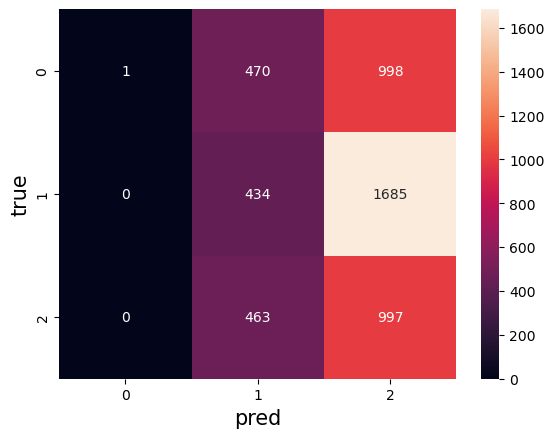

In [19]:
sn.heatmap(cm_wh, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15

Text(50.722222222222214, 0.5, 'true')

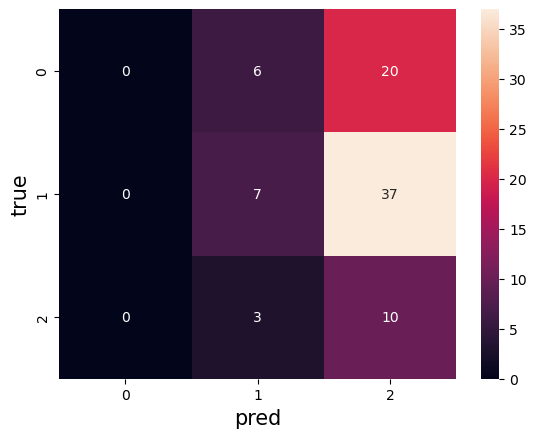

In [21]:
sn.heatmap(cm_as, annot=True, fmt='g')
plt.xlabel('pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('true', fontsize = 15) # y-axis label with fontsize 15